In [273]:
import pydotplus 
import pandas as pd

from IPython.display import Image
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, make_scorer
import numpy as np
from sklearn import model_selection
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_table('german.data-numeric.txt', sep='\\s+', header=None)

In [3]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,1
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,1
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,2


Взяли numerical data, чтобы не париться с категориальными признаками и надеятся, что все сделали за нас. Однако мы потеряли данные об именах столбцах. Потратив некоторое время на сличение ручками, я все таки восстановил некоторые:

In [32]:
columns = [i for i in range(25)]
columns[0] = "Checking account status"
columns[1] = "Duration"
columns[2] = "Credit history"
columns[4] = "Savings account/bonds"
columns[5] = "Present employment since"
columns[6] = "Personal status and sex"
columns[7] = "Present residence since"
columns[8] = "Property"
columns[9] = "Age"
columns[10] = "Other installment plans"
columns[11] = "Existing credits at bank"
columns[12] = "Number of people liable to provide maintenance"
columns[24] = "Good?"
data.columns = columns

In [33]:
data[:10][columns[10:]]

,Other installment plans,Existing credits at bank,Number of people liable to provide maintenance,13,14,15,16,17,18,19,20,21,22,23,Good?
0,3,2,1,2,1,0,0,1,0,0,1,0,0,1,1
1,3,1,1,1,1,0,0,1,0,0,1,0,0,1,2
2,3,1,2,1,1,0,0,1,0,0,1,0,1,0,1
3,3,1,2,1,1,0,0,0,0,0,0,0,0,1,1
4,3,2,2,1,1,1,0,1,0,0,0,0,0,1,2
5,3,1,2,2,1,0,0,1,0,0,0,0,1,0,1
6,3,1,1,1,1,0,0,1,0,0,1,0,0,1,1
7,3,1,1,2,1,0,1,1,0,1,0,0,0,0,1
8,3,1,1,1,1,0,0,1,0,0,1,0,1,0,1
9,3,2,1,1,1,1,0,1,0,0,1,0,0,0,2


In [57]:
X = data[columns[:-1]]
y = np.array(["Good" if i == 1 else "Bad" for i in np.array(data[columns[-1]])])

In [89]:
def plot_tree(model):
    dot_data = tree.export_graphviz(model, out_file="small_tree.out", 
                             feature_names=columns,  
                             class_names=["Bad", "Good"],  
                             filled=True, rounded=True,  
                             special_characters=True)  
    graph = pydotplus.graphviz.graph_from_dot_file("small_tree.out")  
    return Image(graph.create_png())

In [90]:
model = tree.DecisionTreeClassifier()
model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

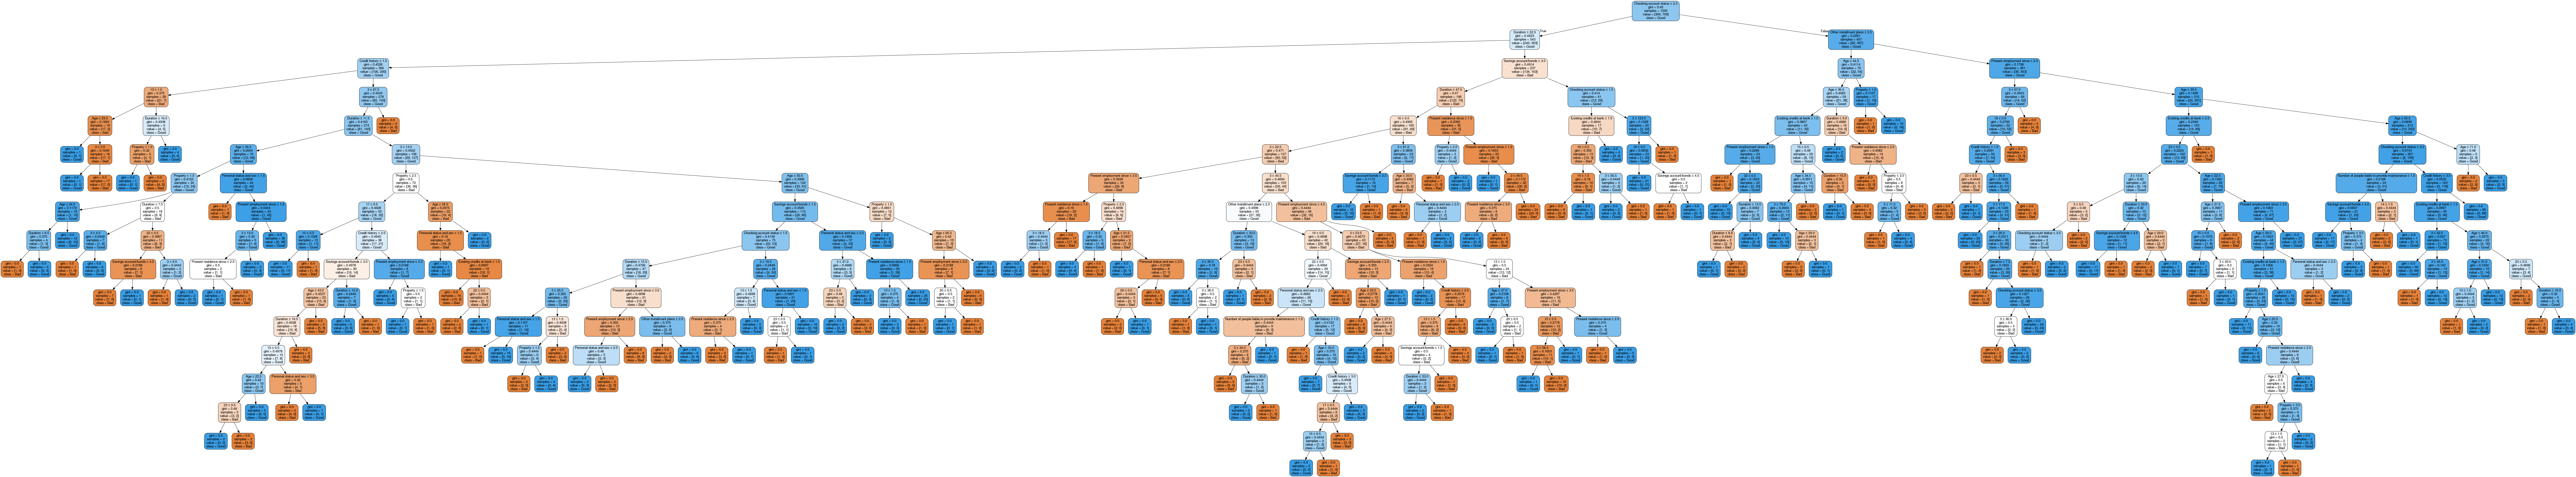

In [91]:
plot_tree(model)

Что же, здоровое дерево. Чтобы проинтерпретировать что-нибудь, давайте уменьшим высоту (все равно алгоритм рекурсивный и вершины будут +- совпадать)

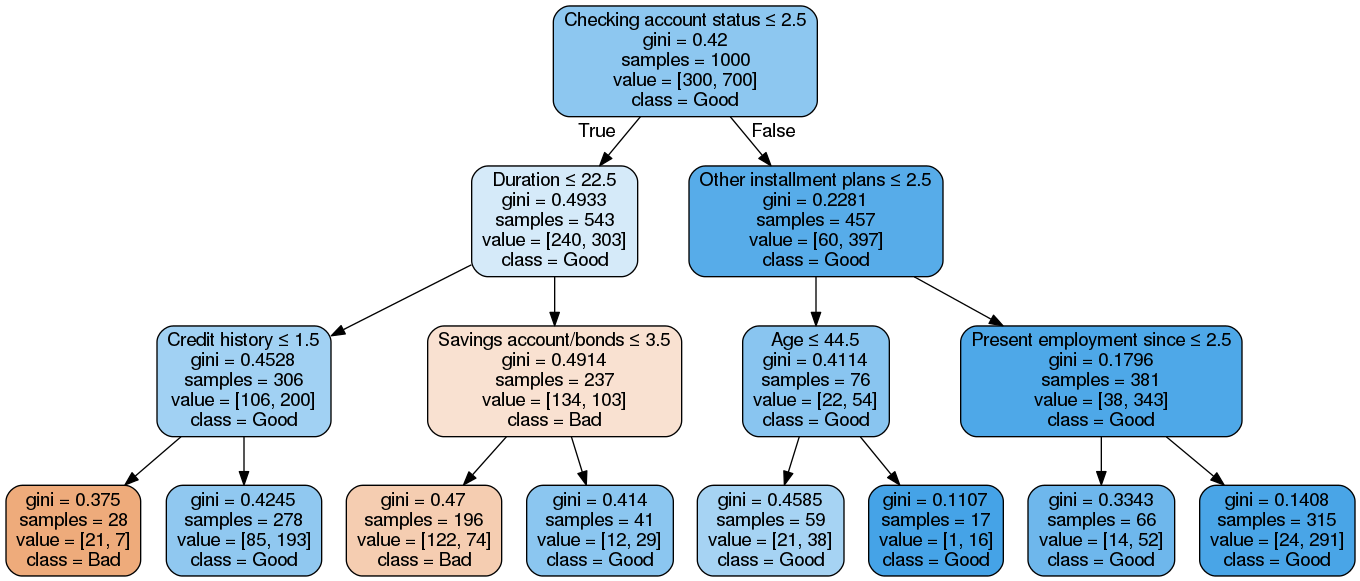

In [94]:
model = tree.DecisionTreeClassifier(max_depth=3)
model.fit(X, y)
plot_tree(model)

Отсюда можно сказать, что тебе не дадут кредит если у тебя мало денег на счетах и ты либо просишь кредит надолго, либо у тебя маленькая кредитная история

In [115]:
def stats(max_depth, X=X, y=y):
    model = tree.DecisionTreeClassifier(max_depth=max_depth)
    k_fold = model_selection.cross_val_score(estimator=model, X=X, y=y).mean()
    
    model = tree.DecisionTreeClassifier(max_depth=max_depth)
    model.fit(X, y)
    accuracy = accuracy_score(y, model.predict(X))
    return [k_fold, accuracy]

In [97]:
statistics = [stats(depth) for depth in xrange(1, 100)]

In [99]:
statistics = np.array(statistics)

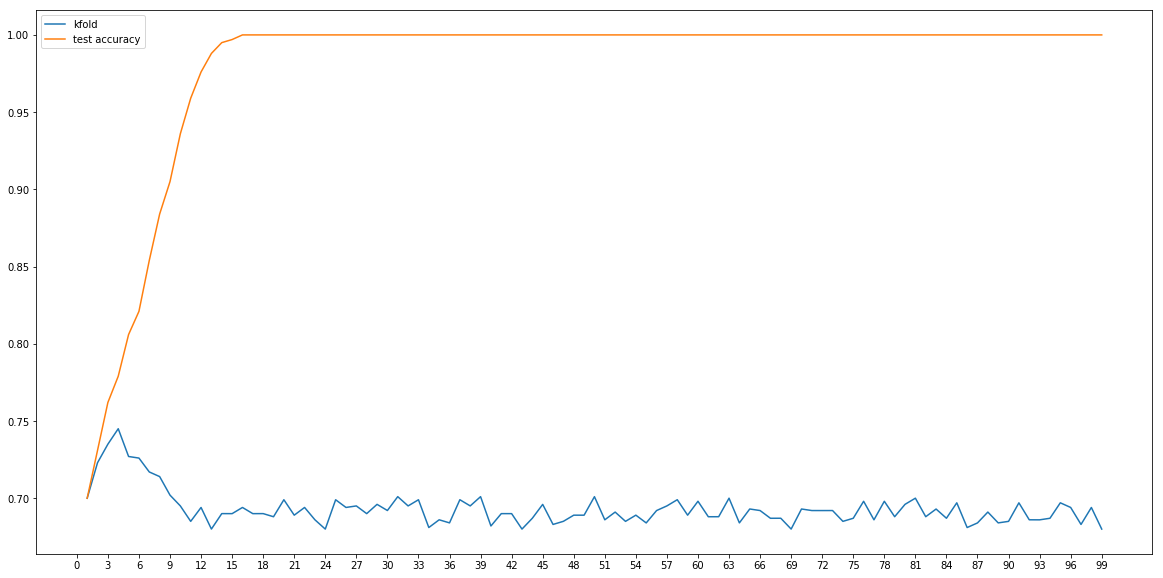

In [104]:
plt.figure(figsize=(20, 10))
x = np.arange(1, 100)
plt.plot(x, statistics[:, 0], label='kfold')
plt.plot(x, statistics[:, 1], label='test accuracy')
plt.legend()
plt.xticks(np.arange(0, 100, 3))
plt.show()

In [105]:
stats(None)

[0.68803234372096644, 1.0]

In [111]:
print(np.max(statistics[:, 0]))
np.argmax(statistics[:, 0]) + 1

0.745002487517


4

качество на кросс-валидации растет в начале (до max_depth = 4) а потом падает. 
Accuracy же растет -- неудевительно, дерево видимо подгоняется.

Максимальный cross_val_score которого достигли -- 74%

Товарищи подсказывают воспользоваться oversampling для балансировки классов. Дейтсвительно, что-то такое было на лекции, давайте прислушаемся к совету

In [112]:
from imblearn.over_sampling import RandomOverSampler

In [114]:
new_X, new_y = RandomOverSampler().fit_sample(X, y)

In [116]:
statistics = [stats(depth, new_X, new_y) for depth in xrange(1, 100)]

In [117]:
statistics = np.array(statistics)

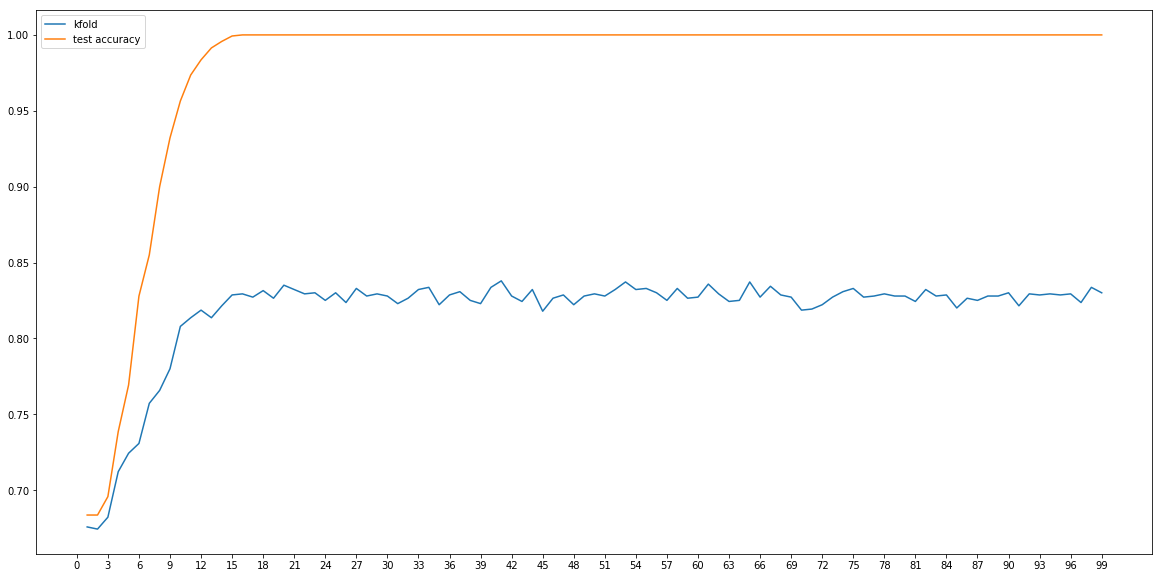

In [118]:
plt.figure(figsize=(20, 10))
x = np.arange(1, 100)
plt.plot(x, statistics[:, 0], label='kfold')
plt.plot(x, statistics[:, 1], label='test accuracy')
plt.legend()
plt.xticks(np.arange(0, 100, 3))
plt.show()

In [119]:
print(np.max(statistics[:, 0]))
np.argmax(statistics[:, 0]) + 1

0.837903353998


41

И правда, повысили качество до 83% 

# 2
*Реализуйте свой класс DecisionTree, имеющий методы fit и predict, позволяющие соответ-
ственно обучить решающее дерево по матрице признаков X_train и ответам y_train, а затем
спрогнозировать ответы на тестовой выборке X_test. Оцените качество работы вашего дерева
на тестовой выборке*

In [122]:
from sklearn.datasets import load_boston

In [219]:
data = load_boston()

In [220]:
X = data.data
y = data.target

In [132]:
X.shape

(506, 13)

In [266]:
class Node(object):
        def init_terminal(self, y):
            self.answer = y.mean()
        
        def init_non_terminal(self, feature, threshold):
            self.feature = feature
            self.threshold = threshold
        
        def __init__(*args):
            self = args[0]
            self.left = None
            self.right = None
            self.is_terminal = args[1]
            if (self.is_terminal):
                self.init_terminal(args[2])
            else:
                self.init_non_terminal(args[2], args[3])
                
        def decide(self, x):
            if (self.is_terminal):
                return self.answer
            if (x[self.feature] < self.threshold):
                return self.left.decide(x)
            return self.right.decide(x)

        
def _H(y):
    if (len(y)):
        return y.var()
    return 10 ** 18

def _G(left_y, right_y):
    if len(left_y) == 0 or len(right_y) == 0:
        return 10 ** 18
    Q = len(left_y) + len(right_y)
    return 1.0 * len(left_y) / Q * _H(left_y) + \
           1.0 * len(right_y) / Q * _H(right_y)

def _get_threshold(i, Y):
    if (i == 0):
        return Y[i] - 0.5
    else:
        return 1.0 * (Y[i] + Y[i - 1]) / 2 
        
class DecisionTree(object):
    def __init__(self, max_depth=4):
        self.max_depth = max_depth
        self.root = None
        
   
    
    def _build(self, parent, my_type, depth, X, y):
        me = None
        if (depth == self.max_depth or len(y) == 1):
            if (my_type == 'left'):
                me = parent.left = Node(True, y)
            else:
                me = parent.right = Node(True, y)
            return
        features = []
        for feature in xrange(X.shape[1]):
            Y = sorted(X[:, feature])
            thresholds = []
            for i in xrange(X.shape[0]):
                th = _get_threshold(i, Y)
                left_y = y[X[:, feature] < th]
                right_y = y[X[:, feature] >= th]
                
                thresholds.append(_G(left_y, right_y))
            features += [[np.min(thresholds), 
                          _get_threshold(np.argmin(thresholds), Y)]]
        features = np.array(features)
        feature = np.argmin(features[:, 0])
        th = features[feature][1]

        left_X = X[X[:, feature] < th]
        right_X = X[X[:, feature] >= th]
        left_y = y[X[:, feature] < th]
        right_y = y[X[:, feature] >= th]
        if (my_type == 'left'):
            me = parent.left = Node(False, feature, th)
        else:
            me = parent.right = Node(False, feature, th)
        self._build(me, 'left', depth + 1, left_X, left_y)
        self._build(me, 'right', depth + 1, right_X, right_y)
    
    def fit(self, X, y):
        self.root = Node(False, 0, 0)
        self._build(self.root, 'left', 1, X, y)
        self.root = self.root.left
        
    def predict(self, X):
        ans = []
        for x in X:
            ans += [self.root.decide(x)]
        return np.array(ans)

def print_tree(node, depth):
    print '-' * depth,
    if (node.is_terminal):
        print node.answer 
    else:
        print_tree(node.left, depth + 1)
        print node.feature, node.threshold
        print_tree(node.right, depth + 1)
        
        

In [307]:
x = DecisionTree(max_depth=10)

Посмотрим на кросс-валидацию:

In [308]:
from sklearn import cross_validation

In [309]:
score = []
for train_indices, test_indices in cross_validation.KFold(len(y), n_folds = 5, random_state=1):
    x.fit(X[train_indices], y[train_indices])   
    score += [((y[test_indices] - x.predict(X[test_indices])) ** 2).sum()]
print(np.mean(score))

3970.66849491


In [310]:
x = tree.DecisionTreeRegressor(max_depth=10)

In [311]:
score = []
for train_indices, test_indices in cross_validation.KFold(len(y), n_folds = 5, random_state=1):
    x.fit(X[train_indices], y[train_indices])   
    score += [((y[test_indices] - x.predict(X[test_indices])) ** 2).sum()]
print(np.mean(score))

4109.5681824


Неплохо. А проведем тест из задания:

In [313]:
train_indices = range(0, int(len(y) * 0.75))
test_indices = range(int(len(y) * 0.75), len(y))

In [322]:
x = DecisionTree(max_depth=4)
x.fit(X[train_indices], y[train_indices])
print(((y[test_indices] - x.predict(X[test_indices])) ** 2).sum())

4754.06820522


In [316]:
x = tree.DecisionTreeRegressor(max_depth=4)
x.fit(X[train_indices], y[train_indices])
print(((y[test_indices] - x.predict(X[test_indices])) ** 2).sum())

2821.90062248


Well